# estimate dispersal rates

In [4]:
import numpy as np
import tsconvert
import sparg2
import glob
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import scipy
import pyproj
import re
import tskit
import random
# to see plotly in jupyterlab
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

## load trees

In [5]:
def load_trees(newickfile, max_n_trees=1e6):
    '''load newick files as list of tree sequences'''
    
    tss = []
    with open(newickfile, mode='r') as file:
        for i,line in enumerate(file): 
            if i>0 and i<max_n_trees+1: #skip header and don't load too many trees
                tree = line.split()[4] #extract newick string only (Relate adds some info beforehand)
                tss.append(tsconvert.from_newick(tree)) #convert to tskit "tree sequence" (only one tree)
    
    return tss

WARNING: loading many tskit trees can take a long time (~5m for 1000 trees)

In [ ]:
CHR = 4 #CHOOSE CHROMOSOME 
Ne = 1e5 #choose Ne prior (very little effect)
m = '7e-9' #choose mu prior (unknown effect)
basename = '../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize'

In [7]:
bps = [] #pairs of start and stop sites (not necessarily in numerical order!) these are the positions of the first and last SNP in each tree, not the actual breakpoints
tsss = [] #treeseqs (in same order as bps)
string = basename + '_bps*.newick'
for newickfile in glob.iglob(string%(CHR,Ne,m)):
    bps.append(list(map(int,re.search('bps(.+?).newick', newickfile).group(1).split('-')))) #load bps at each tree
    tsss.append(load_trees(newickfile, max_n_trees=1000)) #load trees

number of loci

In [8]:
nloci = len(tsss)
nloci

138

number of trees per locus

In [9]:
ntrees = len(tsss[0])
ntrees

1000

draw the trees at a few loci to see how much variation there is in branch lengths

In [11]:
y_tick_pos = [1e0,1e1,1e2,1e3,1e4,1e5,1e6]
for tss in tsss[:2]: #careful displaying too many trees!
    
    svg_trees = []
    for ts in tss[:2]:
        svg_trees.append(ts.draw_svg(node_labels=dict(), time_scale="log_time", y_axis=True, size=(1e3/2,1e3/2), y_ticks=y_tick_pos, min_time=0, max_time=y_tick_pos[-1]))

    #must be way to do this without listing tree indices explicitly!
    no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'
    display(HTML(no_wrap_div.format(svg_trees[0],svg_trees[1])))

note that sample node ids are the same across trees at a locus, but not across loci

In [12]:
print(tsss[0][0].samples())
print(tsss[0][1].samples())
print(tsss[1][0].samples())

[  3   4  11  13  17  18  19  21  22  23  25  31  32  33  34  35  37  41
  43  44  45  47  48  51  52  53  55  56  63  65  69  70  73  74  77  79
  80  83  84  85  87  89  90  91  93  95  97  99 100 101 102 103 107 109
 110 113 115 117 119 120 123 124 125 127 129 130]
[  3   4  11  13  17  18  19  21  22  23  25  31  32  33  34  35  37  41
  43  44  45  47  48  51  52  53  55  56  63  65  69  70  73  74  77  79
  80  83  84  85  87  89  90  91  93  95  97  99 100 101 102 103 107 109
 110 113 115 117 119 120 123 124 125 127 129 130]
[  5   7   8  11  13  14  17  19  21  23  24  27  29  30  31  33  35  36
  41  42  45  49  50  51  53  55  56  57  59  61  62  67  68  71  72  73
  75  76  79  80  83  85  86  87  91  92  93  97  99 100 103 105 106 111
 113 115 116 117 119 120 123 124 125 127 129 130]


the 'name' of a sample node is its index in the list we provided to relate

In [13]:
tsss[0][0].node(tsss[0][0].samples()[0])

Node(id=3, flags=1, time=0.0, population=-1, individual=-1, metadata={'name': '2'})

now load the list of accession ids we gave to relate, which we can access with a 'name' (as the index)

In [14]:
ids = []
ids_file='../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid.samples' %CHR
with open(ids_file, mode='r') as file:
    next(file); next(file) #skip header and 0 row
    for line in file: 
        ids.append(line.strip().split(' ')[0])

## load metadata

all the metadata

In [15]:
metadata = []
with open('../data/66_genomes_summary.txt','r') as file:
    next(file) #skip header
    for line in file:
        metadata.append(line.strip().split('\t'))

locations (long, lat)

In [16]:
locations = np.array([list(map(float,[i[7].replace(',','.'),i[6].replace(',','.')])) for i in metadata])

but not in same order as our ids. get order

In [17]:
accessions = [i[1].strip().replace('_','.').split('.')[0].replace('"','') for i in metadata]
accessions2 = [i[3] for i in metadata]

In [18]:
order = []
for id in ids:
    try:
        ix = accessions.index(id)
    except:
        ix = accessions2.index(id)
    order.append(ix)
# [[ids[i],accessions[j]] for i,j in enumerate(order)]

reorder to match order of ids

In [19]:
locations_ordered = locations[order]

get PCA group too

In [20]:
group = np.array([i[2] for i in metadata])[order]

In [21]:
population_names, population_ixs = np.unique(group, return_inverse=True)

add to tree sequence

In [22]:
for i,tss in enumerate(tsss):
    for j,ts in enumerate(tss):
        
        # get tables
        tables = ts.dump_tables()

        # update node metadata schema
        schema_dict = tables.nodes.metadata_schema.schema
#         schema_dict["properties"]["group"] = {"type": "string"}
        schema_dict["properties"]["long"] = {"type": "number"}
        schema_dict["properties"]["lat"] = {"type": "number"}
        tables.nodes.metadata_schema = tskit.MetadataSchema(schema_dict)

        # add to metadata
        flags = []
        populations = []
        times = []
        metadata_column = []
        for row in tables.nodes:
            flags.append(row.flags)
            times.append(row.time)
            md = row.metadata
            try:
                ix = int(md['name'])
#                 md['group']=group[ix]
                populations.append(population_ixs[ix])
                md['long'],md['lat']=locations_ordered[ix]
                metadata_column.append(md)
            except:
                metadata_column.append(md)
                populations.append(-1)
                
        # encode and validate metadata
        encoded_metadata_column = [tables.nodes.metadata_schema.validate_and_encode_row(r) for r in metadata_column]
        md, md_offset = tskit.pack_bytes(encoded_metadata_column)
        tables.nodes.set_columns(flags=flags, population=populations, time=times, metadata=md, metadata_offset=md_offset)

        #edit population table
        md, md_offset = tskit.pack_strings(population_names)
        tables.populations.set_columns(metadata=md, metadata_offset=md_offset)
    
        # replace tree sequence 
        tsss[i][j] = tables.tree_sequence()

now draw some trees and color by PCA group

In [24]:
# color by pop
styles = []
for colour, p in zip(['blue', 'green', 'red'], tsss[0][0].populations()): #choose colors to roughly match map below
    # target the symbols only (class "sym")
    s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
    styles.append(s)
css_string = " ".join(styles)

y_tick_pos = [1e0,1e1,1e2,1e3,1e4,1e5,1e6]
for tss in tsss[:2]: #careful displaying too many trees!
    
    svg_trees = []
    for ts in tss[:2]:
        svg_trees.append(ts.draw_svg(node_labels=dict(), 
                                     time_scale="log_time", 
                                     y_axis=True, 
                                     size=(1e3/1.5,1e3/2), 
                                     y_ticks=y_tick_pos, 
                                     min_time=0, 
                                     max_time=y_tick_pos[-1],
                                     style=css_string))

    #must be way to do this without listing tree indices explicitly!
    no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'
    display(HTML(no_wrap_div.format(svg_trees[0],svg_trees[1])))

plot locations (check against fig 1a in https://www.nature.com/articles/s41586-023-06062-z)

In [25]:
px.scatter_geo(lon=locations_ordered[:,0],lat=locations_ordered[:,1], color=group, hover_name=ids)

## process trees

In [26]:
def shared_times(tree, samples, tCutoff=None):
    '''shared times between pairs of samples in tskit tree'''

    T = tree.time(tree.root) #tmrca
    k = len(samples)
    sts = np.zeros((k,k))
    for i in range(k):
        sts[i,i] = T #shared time with self
        for j in range(i):
            st = T - tree.tmrca(samples[i],samples[j]) #shared time of pair
            sts[i,j] = st
            sts[j,i] = st

    if tCutoff is None or tCutoff > T:
        return [sts], [[samples[i] for i in range(k)]] #return a single tree
            
    else:
        shared_time = tCutoff - (T-sts) #shared time since tCutoff

        # get shared times and samples in each subtrees
        sts = [] #start list with shared times in subtree with i
        smpls = [] #samples in this subtree
        taken = [False for _ in range(k)]
        while sum(taken) < k: #while some samples not yet in a subtree
            i = np.argmax(taken == False) #choose next sample not yet in a subtree
            withi = shared_time[i] >= 0 #true if shares time with i
            timesi = shared_time[withi][:, withi] #shared times of subtree with i
            timesi = timesi - np.min(timesi) #trim
            sts.append(timesi) #append        
            smpls.append(samples[np.where(withi)[0]]) #samples in this subtree
            taken = np.array([i[0] or i[1] for i in zip(taken, withi)]) #samples already in a subtree
            
        return sts, smpls #return list of shared times and samples in each subtree

In [27]:
def coal_times(tree):
    '''coalescence times in tskit tree'''

    cts = [tree.time(i) for i in tree.nodes() if not tree.is_sample(i)]
    
    return sorted(cts)

In [28]:
def times(tss, tCutoff=None):
    '''shared times and coalescence times in list of one-tree tskit treesequences'''

    stss = [] #shared times between each pair of samples
    smplss = [] #order of samples in shared times matrix
    ctss = [] #coalescence times
    
    for ts in tss:
        
        tree = ts.first()
        sts, smpls = shared_times(tree, ts.samples(), tCutoff)
        cts = coal_times(tree)
        smpls = [[int(ts.node(node).metadata['name']) for node in s] for s in smpls] #to align with metadata
        
        stss.append(sts)
        smplss.append(smpls)
        ctss.append(cts)

    return stss, smplss, ctss

In [29]:
TCUT = None #CHOOSE TIME CUTOFF

stsss = []
smplsss = []
ctsss = []
for tss in tsss: #for each locus
    stss, smplss, ctss = times(tss, tCutoff=TCUT)
    stsss.append(stss)
    smplsss.append(smplss)
    ctsss.append(ctss)

## mle dispersal

In [31]:
def mle_dispersal_tree(locations, shared_times):
    """Maximum likelihood estimate of dispersal rate given locations and shared times between lineages.

    Parameters:
        locations (array-like): Locations. An n x d array, where n is the number of locations and d is the number of spatial dimensions.
        shared_time (array-like): Shared times between lineages. An n x n array, where n is the number of lineages (arranged in same order as locations). 
    
    Returns:
        Maximum likelihood dispersal rate as a d x d covariance matrix.
    """

    n = len(locations) #number of samples
    Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[:-1]; #matrix for mean centering, which drops last sample (because we lose a degree of freedom when mean centering)
    locs = np.matmul(Tmat, locations) #mean center locations 
    stimes = np.matmul(Tmat, np.matmul(shared_times, np.transpose(Tmat))) #mean center shared times
    Tinv = np.linalg.pinv(np.array(stimes)) #invert shared time matrix

    return np.matmul(np.matmul(np.transpose(locs), Tinv), locs) / (n - 1) #mle dispersal rate, corrected to be unbiased

calculate mle dispersal rate for each subtree in each tree at each locus at all loci, to see all the variation

In [32]:
mles = []
for l,stss in enumerate(stsss): #loci
    mles_locus = []
    for i,sts in enumerate(stss): #trees
        mles_tree = []
        for j,st in enumerate(sts): #subtrees
            if len(smplss[l][i][j]) > 1: #need more than 1 sample in subtree to estimate dispersal rate 
                locs = [locations_ordered[k] for k in smplss[l][i][j]]
#                 random.shuffle(locs) #random shuffle to see if our estimates are reasonable
                mle_subtree = mle_dispersal_tree(locations=locs, shared_times=st)
                mles_tree.append(mle_subtree)
        mles_locus.append(mles_tree)
    mles.append(mles_locus)

convert from degrees to kms

In [33]:
def mles_to_km2(mle, meanlon):
    'convert long/lat variances to kilometers squared'
    return mle[0][0] * 110**2, mle[1][1] * (np.cos(meanlon * np.pi/180)*111)**2

In [34]:
meanlon = np.mean(locations_ordered,axis=0)[0]
mle_km2 = [[[mles_to_km2(mle, meanlon) for mle in mles_sub] for mles_sub in mles_locus] for mles_locus in mles]

plot

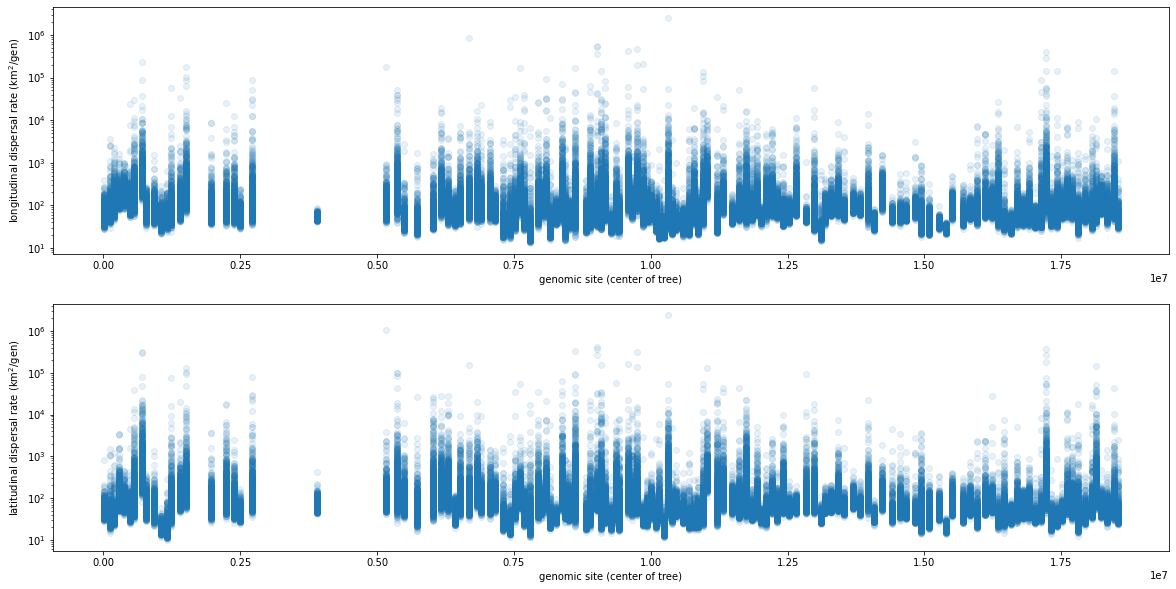

In [35]:
fig, axs = plt.subplots(2,1,figsize=(20,10))

plot_data=[]
for i,mles_locus in enumerate(mle_km2):
    for j,mles_tree in enumerate(mles_locus):
        for k,mle_subtree in enumerate(mles_tree):
            x = bps[i][0] + (bps[i][1] - bps[i][0])/2 #center of tree
            plot_data.append([x,mle_subtree[0],mle_subtree[1]]) #sigma^2
plot_data=np.array(plot_data)

# raw_avgs = np.mean(plot_data, axis=0)[1:]

for i in range(2):
    axs[i].scatter(plot_data[:,0], plot_data[:,i+1], alpha=0.1)
#     axs[i].plot(plot_data[:,0], [raw_avgs[i] for _ in plot_data[:,0]], c='k', alpha=0.5)
for ax in axs:
    ax.set_xlabel('genomic site (center of tree)')            
    ax.set_yscale('log')
#     ax.set_ylim(1e-2,1e2)
axs[0].set_ylabel('longitudinal dispersal rate ($\mathrm{km}^2/\mathrm{gen}$)')
axs[1].set_ylabel('latitudinal dispersal rate ($\mathrm{km}^2/\mathrm{gen}$)')

# plt.subplots_adjust(wspace=0.25)

plt.show()

we can also get the max likelihood estimates over subtrees and loci.

in the case where we only have 1 tree per locus and don't importance sample, the mle is a weighted average of mles at each subtree

In [36]:
def mle_dispersal_exact(locations, shared_times, samples, tree_ix=0):
        
    """
    Analytically calculate maximum likelihood dispersal rate given sample locations and shared time matrices.
    """
    
    d = len(locations[0]) #number of spatial dimensions
    
    Ksum = 0
    KVsum = np.zeros((d,d))
    # loop over loci
    for locus,stss in enumerate(shared_times):

        sts = stss[tree_ix] #list of shared time matrices for each subtree
        sample_lists = samples[locus][tree_ix] #list of sample lists for each subtree

        ksum = 0
        kvsum = np.zeros((d,d))
        # loop over subtrees
        for subtree,st in enumerate(sts): 

            sample_list = sample_lists[subtree]
            k = len(sample_list)

            # calculate subtree weight and weighted mle dispersal rate
            if k > 1: #need more than 1 sample to estimate dispersal rate 
                ksum += k-1 #weight
                locs = [locations[i] for i in sample_list]
                v = mle_dispersal_tree(locations=locs, shared_times=st) #mle
                kvsum += (k-1)*v #weighted mle

        KVsum += kvsum
        Ksum += ksum

    return KVsum/Ksum

calculate for each tree

In [37]:
cmle_trees = []
for i in range(ntrees): #will calculate the mle using the ith tree at each locus
    mle = mle_dispersal_exact(locations_ordered, stsss, smplss, tree_ix=i)
    cmle_trees.append(mle)

plot with all the subtree mles

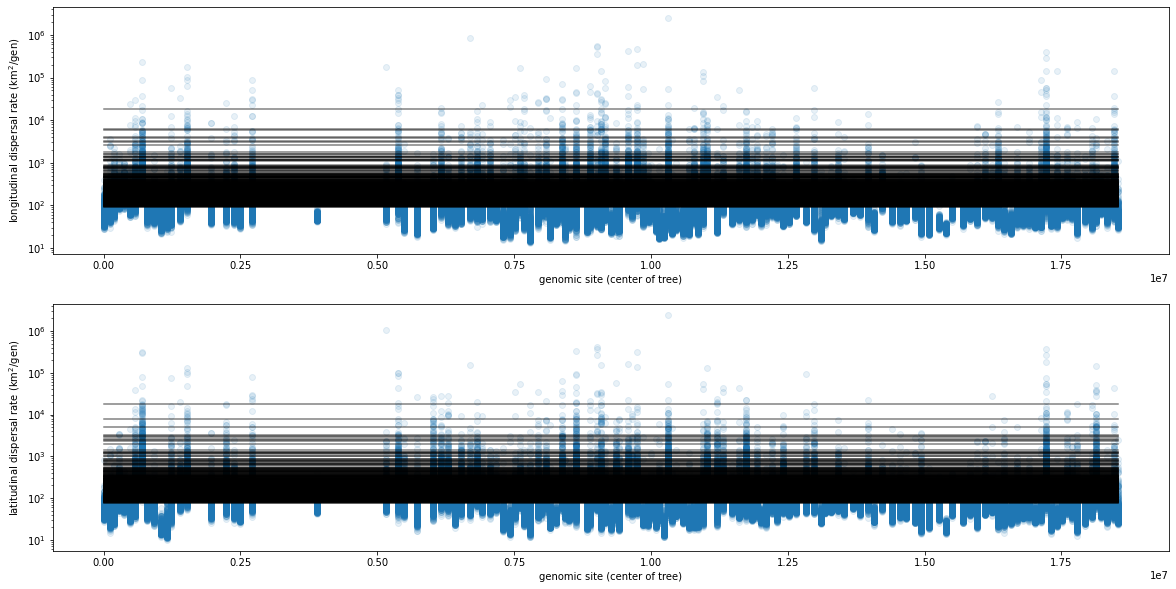

In [38]:
fig, axs = plt.subplots(2,1,figsize=(20,10))

plot_data=[]
for i,mles_locus in enumerate(mle_km2):
    for j,mles_tree in enumerate(mles_locus):
        for k,mle_subtree in enumerate(mles_tree):
            x = bps[i][0] + (bps[i][1] - bps[i][0])/2 #center of tree
            plot_data.append([x,mle_subtree[0],mle_subtree[1]]) #sigma^2
plot_data=np.array(plot_data)

# raw_avgs = np.mean(plot_data, axis=0)[1:]

for i in range(2):
    axs[i].scatter(plot_data[:,0], plot_data[:,i+1], alpha=0.1)
#     axs[i].plot(plot_data[:,0], [raw_avgs[i] for _ in plot_data[:,0]], c='k', alpha=0.5)
for ax in axs:
    ax.set_xlabel('genomic site (center of tree)')            
    ax.set_yscale('log')
#     ax.set_ylim(1e-2,1e2)
axs[0].set_ylabel('longitudinal dispersal rate ($\mathrm{km}^2/\mathrm{gen}$)')
axs[1].set_ylabel('latitudinal dispersal rate ($\mathrm{km}^2/\mathrm{gen}$)')

# plt.subplots_adjust(wspace=0.25)
for cmle in cmle_trees:
    xs = np.linspace(0,np.max(bps),2)
    ys = [mles_to_km2(cmle,meanlon) for _ in xs]
    for i in range(2):
        axs[i].plot(xs, [j[i] for j in ys], c='k', alpha=0.5)

plt.show()

check out the distribution of chromosome-wide estimates

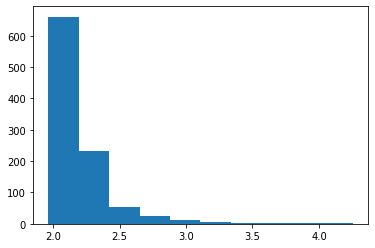

In [51]:
plt.hist([np.log10(mles_to_km2(cmle,meanlon)[0]) for cmle in cmle_trees])
plt.xlabel('log10 dispersal rate')
plt.ylabel('count')
plt.show()

and print the median

In [45]:
np.median([mles_to_km2(cmle,meanlon)[0] for cmle in cmle_trees])

135.66943265368445

# still checking the abopve

if we still have just one tree per locus but want to weight each subtree by its importance weight, then the mle will depend on how these important weights depend on the dispersal rate. if, however, the importance weights do not depend on the dispersal rate then they do not influence the mle and we get what we've just done above. our importance weights do not depend on the dispersal rate because we take the genealogy as fixed and only weight by the probability of the branch lengths, which are independent of dispersal conditioned on the geneaology.

if we have more than 1 tree per locus then it looks like, whether we importance sample or not, we'll have to resort to numerics, because the summation of normal PDFs does not seem to yield a simple MLE. 

however, we could also take a "BLUP" approach and average over the MLE's at each tree, potentially weighting by imporance weights. this provides an approximate but fast estimate when using multiple trees at a locus.

In [71]:
def mle_dispersal_blup(locations, shared_times, samples):
        
    """
    BLUP
    """
    
    d = len(locations[0]) #number of spatial dimensions
    nloci = len(samples) #number of loci
    ntrees = len(samples[0]) #number of trees at a locus
    
#     genome_sum = 0
    ksum = 0
    kvsum = np.zeros((d,d))
    # loop over loci
    for locus,stss in enumerate(shared_times):

#         locus_sum = 0
        kisum = 0
        kvisum = np.zeros((d,d))
        # loop over trees
        for tree, sts in enumerate(stss):

            sample_lists = samples[locus][tree] #list of sample lists for each subtree

            kijsum = 0
            kvijsum = np.zeros((d,d))
            # loop over subtrees
            for subtree,st in enumerate(sts): 

                sample_list = sample_lists[subtree]
                k = len(sample_list)

                # calculate subtree weight and weighted mle dispersal rate
                if k > 1: #need more than 1 sample to estimate dispersal rate 
                    kijsum += k-1 #weight
                    locs = [locations[i] for i in sample_list]
                    v = mle_dispersal_tree(locations=locs, shared_times=st) #mle
                    kvijsum += (k-1)*v #weighted mle

# simple averaging
#             locus_sum += kvijsum/kijsum #add MLE at tree
#         genome_sum += locus_sum/ntrees #add avg MLE over trees
#     return genome_sum/nloci #avg MLE over loci

# weight influenced by number of subtrees
            kisum += kijsum
            kvisum += kvijsum
        ksum += kisum
        kvsum += kvisum
        
    return kvsum/ksum

but unfortunately i think we need to resort to numerics whenever there is more than 1 epoch, regardless the number of trees at a locus.

In [72]:
import time

from scipy.optimize import minimize

def cov_matrix_to_sds_rho(C):
    """
    Convert 2x2 covariance matrix to sds and correlation
    """
    
    sdx = C[0,0]**0.5
    sdy = C[1,1]**0.5
    rho = C[0,1]/(sdx * sdy) #note that small sdx and sdy will raise errors
    
    return [sdx, sdy, rho]

def mle_dispersal(locations, shared_times, samples, covs0=None, phi0=None, bnds=None, 
                  important=True, coal_times=None, logpcoals=None, 
                  scale_phi=None, tCutoff=None, tsplits=[], method='L-BFGS-B', options=None, n=None, 
                  force_numeric=False, BLUP=False):
    """
    Estimate maximum likelihood dispersal rate (and possibly branching rate) given sample locations and processed trees.
    """

    L = len(samples)
    print('inferring dispersal rate from',L,'loci')
    
    M = len(samples[0])
    if n == None:
        n = M
    print('using',n,'of',M,'trees per locus')
    
    d = len(locations[0])
    print('space has',d,'dimensions')
    
    E = len(tsplits) + 1
    print('assuming',E,'epochs')
    
    exact_mle = mle_dispersal_exact(locations, shared_times, samples, tree_ix=0) #exact mle using first tree at each locus
    
    if E==1 and (M==1 or n==1) and not force_numeric:
        
        print('only 1 epoch and only 1 tree per locus: calculating exact MLE analytically')

        return exact_mle #could improve so that n chooses which tree_ix to use

    elif BLUP and not force_numeric:
        
        print('using BLUP approach: weighted average of exact MLEs')
        
        return mle_dispersal_blup(locations, shared_times, samples)
    
    else:
        
        print('estimating the MLE numerically')

        # initial guess at parameters
        if covs0 is None:
            covs0 = [exact_mle for _ in range(E)] #covariance matrices in each epoch
        if important:
            nt = len(locations) #number of lineages at present
            if tCutoff is None:
                n0 = 1 #number of lineages at start
                t = np.mean([stss[0][0][0,0] for stss in shared_times]) #average time to present, over loci (at first tree)
            else:
                n0 = np.mean([len(smpls[0]) for smpls in samples]) #average number of lineages at tCutoff over loci (at first tree)
                t = tCutoff
            phi0 = np.log(nt/n0)/t #phylogenetic birth rate
        
        # convert parameters to list of sds, correlations, and (potentially) birth rate
        x0 = [cov_matrix_to_sds_rho(i) for i in covs0]
        x0 = [item for sublist in x0 for item in sublist]
        if important:
            x0.append(phi0)
        
        # scale phi to put on same scale as dispersal parameters, to improve numerical search
        if important and scale_phi is None:
            scale_phi = np.mean(x0[:-1])/phi0
        
        # negative composite log likelihood ratio, as function of x
        f = _sum_mc(locations, shared_times, samples, important=important, coal_times=coal_times, logpcoals=logpcoals, 
                    scale_phi=scale_phi, tCutoff=tCutoff, tsplits=tsplits, n=n)
    
        # impose bounds on parameters
        if bnds is None:
            bnds = [[(1e-6,None),(1e-6,None),(-0.99,0.99)] for _ in covs0]
            bnds = [item for sublist in bnds for item in sublist]
            if important:
                bnds.append((1e-6,None))
            bnds = tuple(bnds)
        
        print('searching for maximum likelihood parameters...')
        t0 = time.time()

        m = minimize(f, x0=x0, bounds=bnds, method=method, options=options) #find MLE

#         print('the max is ', m.x)
        print('finding the max took', time.time()-t0, 'seconds')

        return m

now let's check that we get something similar numerically

In [73]:
import scipy.sparse as sp

def _sum_mc(locations, shared_times, samples, important=True, coal_times=None, logpcoals=None, 
            scale_phi=1, tCutoff=None, tsplits=[], n=None):
    """
    negative log composite likelihood as a function of list of parameters, x
    """

    E = len(tsplits) + 1 #number of epochs
    L = len(samples) #number of loci
    
    # use n trees at each locus
    M = len(samples[0]) #number of trees at each locus
    if n < M:
        shared_times = [i[0:n] for i in shared_times] 
        samples = [i[0:n] for i in samples]
        if important:
            coal_times = [i[0:n] for i in coal_times]
            logpcoals = [i[0:n] for i in logpcoals]
    if not important:
        coal_times = [None for _ in samples]
        logpcoals = [None for _ in samples]
    
    def sumf(x):
        """
        negative log composite likelihood of list of parameters, x
        """
        
        # convert list of parameters to covariance matrices and birth rate
        covs, phi = _covs_phi(x, E, important) 
        
        # unscale phi
        if important:
            phi = phi/scale_phi
        
        # get negative log composite likelihood 
        g = 0
        for i in range(L):
            # subtract summed log likelihood at each locus 
            g -= _mc(
                     locations=locations,
                     shared_times=shared_times[i],
                     samples=samples[i],
                     covs=covs,
                     important=important,
                     coal_times=coal_times[i],
                     logpcoals=logpcoals[i],
                     phi=phi,
                     tCutoff=tCutoff,
                     tsplits=tsplits
                    )
        return g

    return sumf

def _covs_phi(x, E=1, important=True):
    """
    Convert list of parameters being estimated into covariance matrices and birth rate
    """
    
    # make list of covariance matrices in each epoch
    covs = [] 
    for e in range(E):
        covs.append(sds_rho_to_cov_matrix(x[3*e],x[3*e + 1],x[3*e + 2]))
        # TODO: write this more generally for any dimension

    phi = None
    if important:
        phi = x[-1] #last parameter is birth rate        

    return [covs, phi]

def sds_rho_to_cov_matrix(sdx,sdy,rho):
    """
    Convert sds and correlation to 2x2 covariance matrix
    """
    
    cov = sdx*sdy*rho
    C = np.array([[sdx**2, cov], [cov, sdy**2]])
    
    return C

def _mc(locations, shared_times, samples, covs, important=True, coal_times=None, logpcoals=None, phi=None, tCutoff=None, tsplits=[]):
    """
    Monte Carlo estimate of log of likelihood ratio of the locations given parameters (covs,phi) vs data given standard coalescent
    """

    M = len(samples) #number of trees

    if coal_times is None and logpcoals is None:
        coal_times, logpcoals = [None for _ in range(M)], [None for _ in range(M)]

    LLRs = np.zeros(M) #log likelihood ratio of each tree
    for i, (shared_time, sample, coal_time, logpcoal) in enumerate(zip(shared_times, samples, coal_times, logpcoals)):

        LLRs[i] = _log_likelihoodratio(locations, shared_time, sample, covs, important=important, coal_times=coal_time, logpcoals=logpcoal, phi=phi, tCutoff=tCutoff, tsplits=tsplits)

    LLRhat = _logsumexp(LLRs) - np.log(M) #average over trees at this locus

    return LLRhat

def _log_likelihoodratio(locations, shared_times, samples, covs, important=True, coal_times=None, logpcoals=None, phi=None, tCutoff=None, tsplits=[]):   

    """ 
    Log of likelihood ratio of locations given parameters (covs,phi) vs data given standard coalescent
    """

    LLR = 0
    # loop over subtrees
    for shared_time, sample in zip(shared_times, samples):
        if len(shared_time) > 1: #need at least two samples in subtree to mean center and still have info on dispersal rate
            # add log likelihood of locations given shared evolutionary times and dispersal matrix
            LLR += _location_loglikelihood(locations[sample], shared_time, covs, tsplits)
    if important:
        # add log probability of coalescence times given pure birth process with rate phi
        LLR += _log_birth_density(coal_times, phi, tCutoff) 
        # subtract log probability density of coalescence times under standard coalescent
        LLR -= logpcoals 

    return LLR

def _location_loglikelihood(locations, shared_time, covs, tsplits=[]):

    """
    Log likelihood of locations given mean location and dispersal rate 
    """

    n = len(locations) #number of samples
    Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[0:-1]; #matrix for mean centering and dropping one sample

    # mean center locations
    locs = np.matmul(Tmat, locations) #mean center locations and drop last sample (bc lost a degree of freedom when taking mean); see Lee & Coop 2017 Genetics eq A.16; note numpy broadcasts across the columns in locs
    x = np.transpose(locs).flatten() #write locations as vector (all x locations first, then all y, etc)
    mean = np.zeros(len(x)) #mean of mvn

    # if we don't allow dispersal to vary across time
    if tsplits == []:

        stime = np.matmul(Tmat, np.matmul(shared_time, np.transpose(Tmat))) #mean center shared times
        cov = np.kron(covs[0], stime) #covariance of mvn

    else:

        # times in each epoch
        tsplits = [0] + tsplits #append 0 to front of list of split times
        Ts = [tsplits[i + 1] - tsplits[i] for i in range(len(tsplits) - 1)] #amount of time in all but the most distant epoch
        T = shared_time[0][0] #tmrca
        Ts.append(T - tsplits[-1]) #add time in the most distant epoch

        #shared times in each epoch
        stimes = [] #place to store shared time matrix in each epoch
        stimes.append(np.minimum(shared_time, Ts[-1])) #shared times in most distant epoch
        for i in range(len(tsplits) - 1):
            stimes.append(np.minimum(np.maximum(shared_time - (T - tsplits[-1 - i]), 0), Ts[-2 - i])) #shared times in each most recent epochs (note this means the theta produced will go in chronological order, from most distant to most recent)

        # mean center shared times in each epoch (note this makes each row and column sum to zero)    
        for i,stime in enumerate(stimes):
            stimes[i] = np.matmul(Tmat, np.matmul(stime, np.transpose(Tmat))) #mean center covariance matrix (see eq A.18 in Lee & Coop 2017 Genetics)

        # sum up covariance matrices
        cov = np.zeros((len(x), len(x))) #covariance matrix of mvn
        for i,stime in enumerate(stimes):
            cov += np.kron(covs[i], stime) #covariance matrix for epoch i

    #if np.linalg.matrix_rank(cov) == len(cov):
    return _lognormpdf(x, mean, cov)

def _lognormpdf(x, mu, S, relative=True):

    """
    Calculate log probability density of x, when x ~ N(mu,S)
    """

    # log of coefficient in front of exponential (times -2)
    nx = len(S)
    if relative == False:
        norm_coeff = nx * math.log(2 * math.pi) + np.linalg.slogdet(S)[1]
    else:
        norm_coeff = np.linalg.slogdet(S)[1] #just care about relative likelihood so drop the constant

    # term in exponential (times -2)
    err = x - mu #difference between mean and data
    if sp.issparse(S):
        numerator = spln.spsolve(S, err).T.dot(err) #use faster sparse methods if possible
    else:
        numerator = np.linalg.solve(S, err).T.dot(err) #just a fancy way of calculating err.T * S^-1  * err

    return -0.5 * (norm_coeff + numerator) #add the two terms together

def _logsumexp(a):

    """
    take the log of a sum of exponentials without losing information
    """

    a_max = np.max(a) #max element in list a
    tmp = np.exp(a - a_max) #now subtract off the max from each a before taking exponential (ie divide sum of exponentials by exp(a_max))
    s = np.sum(tmp) #and sum those up
    out = np.log(s) #and take log
    out += a_max  #and then add max element back on (ie multiply sum by exp(a_max), ie add log(exp(a_max)) to logged sum)

    return out

using 1 tree per locus, calculate MLE exactly (as we've done above, but just checking code works)

In [74]:
mle_dispersal(locations_ordered, stsss, smplss, n=1)

inferring dispersal rate from 138 loci
using 1 of 1000 trees per locus
space has 2 dimensions
assuming 1 epochs
only 1 epoch and only 1 tree per locus: calculating exact MLE analytically


array([[0.10272579, 0.0001161 ],
       [0.0001161 , 0.01198601]])

In [37]:
covs0 = None #much faster to start near MLE, which is the default, and used when covs0=None
# covs0 = [np.array([[0.02, 0.01],[0.01, 0.02]])] #takes much longer to start far away but still gets close
mle = mle_dispersal(locations_ordered, stsss, smplss, n=1, force_numeric=True, important=False, covs0=covs0)
sds_rho_to_cov_matrix(mle.x[0],mle.x[1],mle.x[2])

inferring dispersal rate from 138 loci
using 1 of 10 trees per locus
space has 2 dimensions
assuming 1 epochs
estimating the MLE numerically
searching for maximum likelihood parameters...
finding the max took 7.581485271453857 seconds


array([[0.10272917, 0.0001161 ],
       [0.0001161 , 0.01198601]])

great that is very close.

now let's try using all the trees, via the BLUP method

In [75]:
cmle_blup = mle_dispersal(locations_ordered, stsss, smplss, BLUP=True)

inferring dispersal rate from 138 loci
using 1000 of 1000 trees per locus
space has 2 dimensions
assuming 1 epochs
using BLUP approach: weighted average of exact MLEs


and compare to what we get numerically (which should be more accurate)

In [39]:
covs0 = None #much faster to start near MLE
# covs0 = [np.array([[0.02, 0.01],[0.01, 0.02]])] #takes much longer to start far away but still gets close
mle = mle_dispersal(locations_ordered, stsss, smplss, important=False, covs0=covs0)
cmle_numeric = sds_rho_to_cov_matrix(mle.x[0],mle.x[1],mle.x[2])

inferring dispersal rate from 138 loci
using 10 of 10 trees per locus
space has 2 dimensions
assuming 1 epochs
estimating the MLE numerically
searching for maximum likelihood parameters...
finding the max took 167.7567253112793 seconds


plot with all the subtree and tree mles

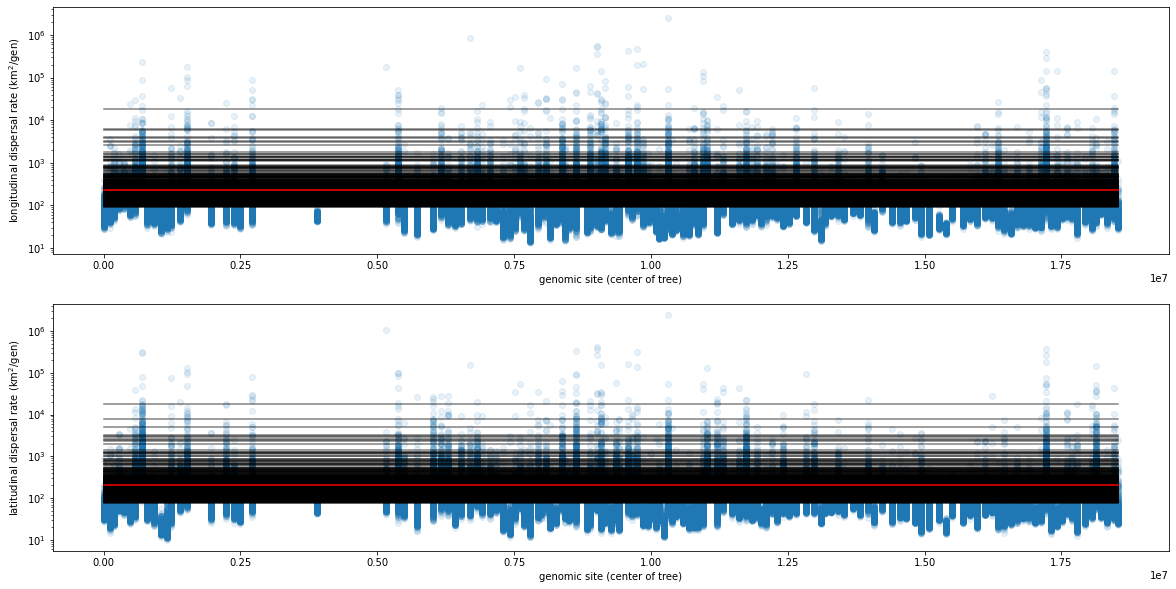

In [76]:
fig, axs = plt.subplots(2,1,figsize=(20,10))

plot_data=[]
for i,mles_locus in enumerate(mle_km2):
    for j,mles_tree in enumerate(mles_locus):
        for k,mle_subtree in enumerate(mles_tree):
            x = bps[i][0] + (bps[i][1] - bps[i][0])/2 #center of tree
            plot_data.append([x,mle_subtree[0],mle_subtree[1]]) #sigma^2
plot_data=np.array(plot_data)

# raw_avgs = np.mean(plot_data, axis=0)[1:]

for i in range(2):
    axs[i].scatter(plot_data[:,0], plot_data[:,i+1], alpha=0.1)
#     axs[i].plot(plot_data[:,0], [raw_avgs[i] for _ in plot_data[:,0]], c='k', alpha=0.5)
for ax in axs:
    ax.set_xlabel('genomic site (center of tree)')            
    ax.set_yscale('log')
#     ax.set_ylim(1e-2,1e2)
axs[0].set_ylabel('longitudinal dispersal rate ($\mathrm{km}^2/\mathrm{gen}$)')
axs[1].set_ylabel('latitudinal dispersal rate ($\mathrm{km}^2/\mathrm{gen}$)')

# plt.subplots_adjust(wspace=0.25)
xs = np.linspace(0,np.max(bps),2)
for cmle in cmle_trees:
    ys = [mles_to_km2(cmle,meanlon) for _ in xs]
    for i in range(2):
        axs[i].plot(xs, [j[i] for j in ys], c='k', alpha=0.5)
        
ys = [mles_to_km2(cmle_blup,meanlon) for _ in xs]
for i in range(2):
    axs[i].plot(xs, [j[i] for j in ys], c='r', alpha=1)
    
# ys = [mles_to_km2(cmle_numeric,meanlon) for _ in xs]
# for i in range(2):
#     axs[i].plot(xs, [j[i] for j in ys], c='orange', alpha=1)

plt.show()

In [79]:
cmle_blup * 110**2

array([[228.08904885,  49.03229936],
       [ 49.03229936, 205.447117  ]])

the BLUP and numeric approach are surprisingly different. it seems like the numeric approach is off. INVESTIGATE!

### importance sampling

now importance sample too

In [51]:
def _log_birth_density(times, phi, tCutoff=None, condition_on_n=True):

    """
    log probability of coalescence times given Yule process with splitting rate phi
    """

    n = len(times) + 1 #number of samples is 1 more than number of coalescence events
    if tCutoff is None:
        T = times[-1]
    else:
        T = min(tCutoff, times[-1]) #furthest time in past we are interested in is the min of the cutoff time and the oldest coalesence event
    times = T - times #switch to forward in time perspective from T
    times = np.sort(times[times>0]) #remove older coalescence events (we'll assume panmixia beyond tCutoff, so this will cancel out in importance sampling)
    n0 = n - len(times) #number of lineages at time T

    logp = 0 #initialize log probability
    prevt = 0 #initialize time
    # probability of each coalescence time
    for i, t in enumerate(times): #for each coalescence event i at time t
        k = n0 + i #number of lineages before the event
        logp += np.log(k * phi) - k * phi *  (t - prevt) #log probability of waiting time  t-prevt (waiting times are exponentially distributed with rate k*phi)
        prevt = t #update time

    #add probability of no coalescence to present time (from most recent coalescence to present, with n samples and rate n*phi)
    logp += - n * phi * (T - prevt)

    #condition on having n samples from n0 in time T
    if condition_on_n:
        logp -= np.log(math.comb(n - 1, n - n0) * (1 - np.exp(-phi * T))**(n - n0)) - phi * n0 * T # see page 234 of https://www.pitt.edu/~super7/19011-20001/19531.pdf for two different expressions

    return logp

def _log_coal_density(times, Nes, epochs=None, tCutoff=None):

    """
    log probability of coalescent times under standard neutral/panmictic coalescent
    """

    if Nes is None:
        print('must supply Ne to get probability of coalescence times')
        return

    if epochs is None and len(Nes) == 1:
        epochs = [0, max(times)] #one big epoch
        Nes = [Nes[0], Nes[0]] #repeat the effective population size so same length as epochs 

    logp = 0 #initialize log probability
    prevt = 0 #initialize time
    prevLambda = 0 #initialize coalescent intensity
    n = len(times) + 1 #number of samples
    if tCutoff is not None:
        times = times[times < tCutoff] #ignore old times
    myIntensityMemos = _coal_intensity_memos(epochs, Nes) #intensities up to end of each epoch

    # probability of each coalescence time
    for i,t in enumerate(times): #for each coalescence event i at time t
        k = n-i #number of lineages remaining
        kchoose2 = k * (k - 1) / 2 #binomial coefficient
        Lambda = _coal_intensity_using_memos(t, epochs, myIntensityMemos, Nes) #coalescent intensity up to time t
        ie = np.digitize(np.array([t]), epochs) #epoch at the time of coalescence
        logpk = np.log(kchoose2 * 1 / (2 * Nes[ie])) - kchoose2 * (Lambda - prevLambda) #log probability (waiting times are time-inhomogeneous exponentially distributed)
        logp += logpk
        prevt = t
        prevLambda = Lambda

    # now add the probability of lineages not coalescing by tCutoff
    if k > 1 and tCutoff is not None: #if we have more than one lineage remaining
        k -= 1 #after the last coalescence event we have one less sample
        kchoose2 = k * (k - 1) / 2 #binomial coefficient
        Lambda = _coal_intensity_using_memos(tCutoff, epochs, myIntensityMemos, Nes) #coalescent intensity up to time tCutoff
        logPk = - kchoose2 * (Lambda - prevLambda) #log probability of no coalescence
        logp += logPk

    return logp[0]

def _coal_intensity_using_memos(t, epochs, intensityMemos, Nes):

    """
    add coal intensity up to time t
    """

    iEpoch = int(np.digitize(np.array([t]), epochs)[0] - 1) #epoch 
    t1 = epochs[iEpoch] #time at which the previous epoch ended
    Lambda = intensityMemos[iEpoch] #intensity up to end of previous epoch
    Lambda += 1 / (2 * Nes[iEpoch]) * (t - t1) #add intensity for time in current epoch
    return Lambda

def _coal_intensity_memos(epochs, Nes):

    """
    coalescence intensity up to the end of each epoch
    """

    Lambda = np.zeros(len(epochs))
    for ie in range(1, len(epochs)):
        t0 = epochs[ie - 1] #start time
        t1 = epochs[ie] #end time
        Lambda[ie] = (t1 - t0) #elapsed time
        Lambda[ie] *= 1 / (2 * Nes[ie - 1]) #multiply by coalescence intensity
        Lambda[ie] += Lambda[ie - 1] #add previous intensity

    return Lambda

In [1]:
def get_epochs(coalfile):
    """Get epochs and population sizes in each from coal file (produced by Relate).

    Parameters:
        coalfile (string): Name of .coal file.

    Returns:
        epochs (numpy array): Start and end times of each epoch.
        Nes (np array): Effective population sizes in each epoch (with last entry repeated).
    """

    epochs = np.genfromtxt(coalfile,skip_header=1,skip_footer=1) #time at which each epoch starts (and the final one ends)
    Nes = 0.5/np.genfromtxt(coalfile,skip_header=2)[2:-1] #effective population size during each epoch (note that the coalescent rate becomes 0 after all trees have coalesced, and so Ne goes to infinity)
    Nes = np.array(list(Nes)+[Nes[-1]]) #add the final size once more to make same length as epochs

    return epochs, Nes

In [2]:
chrs = range(1,6)

fig, ax = plt.subplots()

for i,chr in enumerate(chrs):
    coalfile="../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid_polarized_masked_popsize.coal" %chr
    epochs, Nes = get_epochs(coalfile)
    ax.step(epochs, Nes, label=chr)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('generations ago')
ax.set_ylabel('effective population size')
ax.legend()
ax.set_ylim(ymin=1e4)
    
plt.show()

NameError: name 'plt' is not defined

In [62]:
logpcoals = []
for cts in ctss:
    logpcoals.append(_log_coal_density(times=np.array(cts), Nes=Nes, epochs=epochs, tCutoff=TCUT))

In [64]:
covs0 = None #much faster to start near MLE
# covs0 = [np.array([[0.02, 0.01],[0.01, 0.02]])] #takes much longer to start far away but still gets close
mle = mle_dispersal(locations_ordered, stsss, smplss, force_numeric=True, important=True, covs0=covs0, coal_times=ctsss, logpcoals=logpcoals)
sds_rho_to_cov_matrix(mle.x[0],mle.x[1],mle.x[2])

inferring dispersal rate from 138 loci
using 10 of 10 trees per locus
space has 2 dimensions
assuming 1 epochs
estimating the MLE numerically
searching for maximum likelihood parameters...


TypeError: 'numpy.float64' object is not iterable